<a href="https://colab.research.google.com/github/peterbabulik/QuantumAI/blob/main/CustomZNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit qiskit_aer qiskit-ibm-runtime -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import time
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions

# --- SCIENTIFIC CONFIGURATION ---
API_KEY = "your api here"
BACKEND_NAME = "ibm_torino" # Must be a real device for ZNE to make sense
NUM_QUBITS = 50
SHOTS = 4096 # High shot count for statistical significance

def run_comparative_benchmark():
    print(f"--- 1. INITIALIZING EXPERIMENT (N={NUM_QUBITS}) ---")

    # Setup Service
    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=API_KEY)
    backend = service.backend(BACKEND_NAME)
    print(f"Target Hardware: {backend.name}")

    # --- 2. CIRCUIT PREPARATION (FIXED) ---
    # We must use the exact same circuit for both runs to be scientifically valid.
    print("Building Circuit...")
    feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
    ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')
    circuit = feature_map.compose(ansatz)

    # Transpile ONCE. We must ensure both experiments use the exact same physical qubits.
    print("Compiling (Transpiling) for Hardware...")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    isa_circuit = pm.run(circuit)

    # Define Observable (Z on qubit 0)
    observable = SparsePauliOp(["I" * (NUM_QUBITS - 1) + "Z"])
    isa_observable = observable.apply_layout(isa_circuit.layout)

    # --- 3. DATA PREPARATION ---
    # Fix the seed so this experiment is reproducible
    np.random.seed(42)

    # Generate one single data point and weight set
    input_data = np.random.uniform(0, np.pi, NUM_QUBITS)
    weights = np.random.uniform(0, 2*np.pi, ansatz.num_parameters)
    full_params = np.concatenate([input_data, weights])

    print(f"Parameter Vector Length: {len(full_params)}")

    # --- 4. CONFIGURE RUNTIMES ---

    # CONFIG A: NO MITIGATION (The Control Group)
    # Resilience Level 0 = No error mitigation
    opt_raw = EstimatorOptions()
    opt_raw.resilience_level = 0
    opt_raw.default_shots = SHOTS

    # CONFIG B: ZNE MITIGATION (The Experimental Group)
    # Resilience Level 2 = ZNE (Zero Noise Extrapolation)
    opt_zne = EstimatorOptions()
    opt_zne.resilience_level = 2
    opt_zne.resilience.zne_mitigation = True
    opt_zne.default_shots = SHOTS

    # --- 5. EXECUTION ---
    print("\n--- 5. SUBMITTING JOBS ---")

    # We submit both jobs immediately so they run close together in time
    # (minimizing drift in machine calibration)

    estimator_raw = Estimator(mode=backend, options=opt_raw)
    estimator_zne = Estimator(mode=backend, options=opt_zne)

    print("Submitting Job A: RAW (No Mitigation)...")
    job_raw = estimator_raw.run([(isa_circuit, [isa_observable], [full_params])])
    print(f" -> Job ID A: {job_raw.job_id()}")

    print("Submitting Job B: ZNE (Error Mitigated)...")
    job_zne = estimator_zne.run([(isa_circuit, [isa_observable], [full_params])])
    print(f" -> Job ID B: {job_zne.job_id()}")

    print("\n--- WAITING FOR RESULTS ---")
    # In a real script, you might save IDs here and exit, but we will wait.

    result_raw = job_raw.result()
    print("Job A (Raw) Finished.")

    result_zne = job_zne.result()
    print("Job B (ZNE) Finished.")

    # --- 6. SCIENTIFIC ANALYSIS ---
    val_raw = result_raw[0].data.evs[0]
    val_zne = result_zne[0].data.evs[0]

    diff = abs(val_zne - val_raw)
    improvement = (diff / abs(val_raw)) * 100 if val_raw != 0 else 0

    print("\n" + "="*50)
    print("   RESULTS")
    print("="*50)
    print(f"Backend: {backend.name}")
    print(f"Qubits:  {NUM_QUBITS}")
    print("-" * 50)
    print(f"1. Raw Expectation (Noisy):     {val_raw:.5f}")
    print(f"2. ZNE Expectation (Mitigated): {val_zne:.5f}")
    print("-" * 50)
    print(f"Signal Shift (Noise Impact):    {diff:.5f}")
    print(f"Relative Correction Magnitude:  {improvement:.1f}%")
    print("="*50)
    print("If the shift is significant (>10%),")
    print("it validates the hypothesis that ZNE is required for")
    print("reliable QNN inference at this scale.")

if __name__ == "__main__":
    try:
        run_comparative_benchmark()
    except Exception as e:
        print(f"Error: {e}")

qiskit_runtime_service._discover_account:WARNING:2026-02-02 15:24:31,756: Loading account with the given token. A saved account will not be used.


--- 1. INITIALIZING EXPERIMENT (N=50) ---


qiskit_runtime_service.__init__:WARNING:2026-02-02 15:24:34,504: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-02 15:24:34,505: Using instance: open-instance, plan: open


Target Hardware: ibm_torino
Building Circuit...
Compiling (Transpiling) for Hardware...


/tmp/ipython-input-526671916.py:25: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
/tmp/ipython-input-526671916.py:26: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')


Parameter Vector Length: 250

--- 5. SUBMITTING JOBS ---
Submitting Job A: RAW (No Mitigation)...
 -> Job ID A: d60c3dd7fc0s73auvv20
Submitting Job B: ZNE (Error Mitigated)...
 -> Job ID B: d60c3dibju6s73bcqul0

--- WAITING FOR RESULTS ---
Job A (Raw) Finished.
Job B (ZNE) Finished.

   RESULTS
Backend: ibm_torino
Qubits:  50
--------------------------------------------------
1. Raw Expectation (Noisy):     -0.13525
2. ZNE Expectation (Mitigated): -0.12329
--------------------------------------------------
Signal Shift (Noise Impact):    0.01196
Relative Correction Magnitude:  8.8%
If the shift is significant (>10%),
it validates the hypothesis that ZNE is required for
reliable QNN inference at this scale.


log:

--- 5. SUBMITTING JOBS ---
Submitting Job A: RAW (No Mitigation)...
 -> Job ID A: d60c0it7fc0s73auvs30
Submitting Job B: ZNE (Error Mitigated)...
 -> Job ID B: d60c0j2bju6s73bcqrog

--- WAITING FOR RESULTS ---
Job A (Raw) Finished.
Job B (ZNE) Finished.

==================================================
   RESULTS
==================================================
Backend: ibm_torino
Qubits:  50
--------------------------------------------------
1. Raw Expectation (Noisy):     -0.16748
2. ZNE Expectation (Mitigated): -0.13364
--------------------------------------------------
Signal Shift (Noise Impact):    0.03384
Relative Correction Magnitude:  20.2%
==================================================

--- 5. SUBMITTING JOBS ---
Submitting Job A: RAW (No Mitigation)...
 -> Job ID A: d60c2sd7fc0s73auvuhg
Submitting Job B: ZNE (Error Mitigated)...
 -> Job ID B: d60c2sl7fc0s73auvui0

--- WAITING FOR RESULTS ---
Job A (Raw) Finished.
Job B (ZNE) Finished.

==================================================
   RESULTS
==================================================
Backend: ibm_torino
Qubits:  50
--------------------------------------------------
1. Raw Expectation (Noisy):     -0.15527
2. ZNE Expectation (Mitigated): -0.16893
--------------------------------------------------
Signal Shift (Noise Impact):    0.01365
Relative Correction Magnitude:  8.8%
==================================================


--- 5. SUBMITTING JOBS ---
Submitting Job A: RAW (No Mitigation)...
 -> Job ID A: d60c3dd7fc0s73auvv20
Submitting Job B: ZNE (Error Mitigated)...
 -> Job ID B: d60c3dibju6s73bcqul0

--- WAITING FOR RESULTS ---
Job A (Raw) Finished.
Job B (ZNE) Finished.

==================================================
   RESULTS
==================================================
Backend: ibm_torino
Qubits:  50
--------------------------------------------------
1. Raw Expectation (Noisy):     -0.13525
2. ZNE Expectation (Mitigated): -0.12329
--------------------------------------------------
Signal Shift (Noise Impact):    0.01196
Relative Correction Magnitude:  8.8%
==================================================
If the shift is significant (>10%),
it validates the hypothesis that ZNE is required for
reliable QNN inference at this scale.

qiskit_runtime_service._discover_account:WARNING:2026-02-02 13:15:45,675: Loading account with the given token. A saved account will not be used.


--- 1. PREPARING CUSTOM ZNE (Tanh Fit) ON ibm_torino ---


qiskit_runtime_service.__init__:WARNING:2026-02-02 13:15:48,170: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-02 13:15:48,171: Using instance: open-instance, plan: open
/tmp/ipython-input-661198515.py:31: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, en

Transpiling...
--- 2. SUBMITTING JOB (Noise Factors: [1, 3, 5]) ---
Job ID: d60a71l7fc0s73auth2g
Waiting for completion...

--- 3. RAW DATA FROM QUANTUM COMPUTER ---
Noise Factor 1.0x : Expectation = 0.29715
Noise Factor 3.0x : Expectation = 0.18938
Noise Factor 5.0x : Expectation = 0.10463

--- 4. FITTING CUSTOM TANH MODEL ---
Model Parameters: a=0.3558, b=-0.3997, c=0.1477
>> Extrapolated Value (x=0): 0.35577
>> Standard Linear Value     : 0.34144

Plot saved to 'zne_tanh_analysis.png'. Include this in your paper!


/tmp/ipython-input-661198515.py:82: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(tanh_decay_model, NOISE_FACTORS, raw_evs, p0=[-0.2, 0.1, 0.5], maxfev=5000)


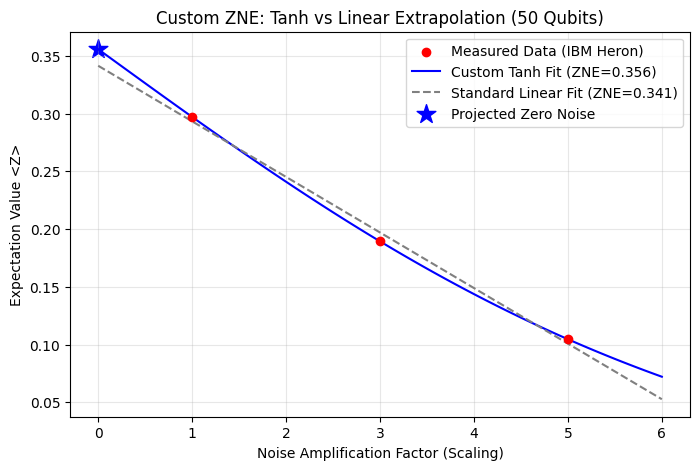

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, EstimatorOptions

# --- CONFIGURATION ---
API_KEY = "your api here"
BACKEND_NAME = "ibm_torino"
NUM_QUBITS = 50
SHOTS = 4096
NOISE_FACTORS = [1, 3, 5]  # We measure at these noise levels

# --- DEFINING YOUR CUSTOM MODEL ---
# User Request: Tanh Extrapolation
# Logic: We model the decay of signal as a tanh function of noise level (x)
# f(x) = a + b * tanh(c * x)
# At x=0 (Zero Noise), the value is 'a'.
def tanh_decay_model(x, a, b, c):
    return a + b * np.tanh(c * x)

def run_custom_zne():
    print(f"--- 1. PREPARING CUSTOM ZNE (Tanh Fit) ON {BACKEND_NAME} ---")

    service = QiskitRuntimeService(channel="ibm_quantum_platform", token=API_KEY)
    backend = service.backend(BACKEND_NAME)

    # 1. Circuit (Same as before for consistency)
    feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
    ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')
    circuit = feature_map.compose(ansatz)

    print("Transpiling...")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    isa_circuit = pm.run(circuit)

    observable = SparsePauliOp(["I" * (NUM_QUBITS - 1) + "Z"])
    isa_observable = observable.apply_layout(isa_circuit.layout)

    # 2. Data
    np.random.seed(42)
    full_params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)

    # 3. Configure Runtime to return RAW NOISE DATA
    options = EstimatorOptions()
    options.default_shots = SHOTS
    options.resilience_level = 2
    options.resilience.zne_mitigation = True
    options.resilience.zne.noise_factors = NOISE_FACTORS
    # We set a dummy extrapolator because we will ignore it and do our own
    options.resilience.zne.extrapolator = "linear"

    print(f"--- 2. SUBMITTING JOB (Noise Factors: {NOISE_FACTORS}) ---")
    estimator = Estimator(mode=backend, options=options)

    # Run
    job = estimator.run([(isa_circuit, [isa_observable], [full_params])])
    print(f"Job ID: {job.job_id()}")
    print("Waiting for completion...")
    result = job.result()

    # --- 4. EXTRACT RAW DATA FOR CUSTOM FITTING ---
    # Qiskit V2 returns the expectation values at each noise factor in 'evs_noise_factors'
    # Shape is usually (1, 1, num_factors) -> we flatten it
    raw_evs = result[0].data.evs_noise_factors[0].flatten()

    print("\n--- 3. RAW DATA FROM QUANTUM COMPUTER ---")
    for nf, ev in zip(NOISE_FACTORS, raw_evs):
        print(f"Noise Factor {nf:.1f}x : Expectation = {ev:.5f}")

    # --- 5. PERFORM CUSTOM TANH EXTRAPOLATION ---
    print("\n--- 4. FITTING CUSTOM TANH MODEL ---")

    try:
        # Fit the data to: a + b * tanh(c * x)
        # Initial guess (p0) helps convergence:
        # a (intercept) ~ value at noise 1
        # b (scale) ~ -0.1 (decaying)
        # c (rate) ~ 0.5
        popt, pcov = curve_fit(tanh_decay_model, NOISE_FACTORS, raw_evs, p0=[-0.2, 0.1, 0.5], maxfev=5000)

        # The Zero Noise Limit is f(0)
        # f(0) = a + b*tanh(0) = a
        zne_limit_tanh = popt[0]

        print(f"Model Parameters: a={popt[0]:.4f}, b={popt[1]:.4f}, c={popt[2]:.4f}")
        print(f">> Extrapolated Value (x=0): {zne_limit_tanh:.5f}")

        # Compare with Linear (Standard Qiskit)
        # We can calculate linear fit manually to compare
        slope, intercept = np.polyfit(NOISE_FACTORS, raw_evs, 1)
        zne_limit_linear = intercept

        print(f">> Standard Linear Value     : {zne_limit_linear:.5f}")

        # --- 6. PLOT FOR THE PAPER ---
        plt.figure(figsize=(8, 5))

        # Plot Data Points
        plt.scatter(NOISE_FACTORS, raw_evs, color='red', label='Measured Data (IBM Heron)', zorder=5)

        # Plot Fits
        x_range = np.linspace(0, 6, 100)
        plt.plot(x_range, tanh_decay_model(x_range, *popt), label=f'Custom Tanh Fit (ZNE={zne_limit_tanh:.3f})', color='blue')
        plt.plot(x_range, slope*x_range + intercept, label=f'Standard Linear Fit (ZNE={zne_limit_linear:.3f})', color='gray', linestyle='--')

        # Formatting
        plt.scatter([0], [zne_limit_tanh], color='blue', marker='*', s=200, label='Projected Zero Noise')
        plt.xlabel('Noise Amplification Factor (Scaling)')
        plt.ylabel('Expectation Value <Z>')
        plt.title('Custom ZNE: Tanh vs Linear Extrapolation (50 Qubits)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.savefig("zne_tanh_analysis.png")
        print("\nPlot saved to 'zne_tanh_analysis.png'. Include this in your paper!")

    except Exception as e:
        print(f"Fitting failed: {e}")
        print("Tip: If data is too noisy, Tanh fitting might be unstable. Try collecting more shots.")

if __name__ == "__main__":
    run_custom_zne()

In [7]:
import numpy as np
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator # Perfect Simulator

# --- 1. RECONSTRUCT THE EXPERIMENT ---
NUM_QUBITS = 20
np.random.seed(42) # <--- CRITICAL: This generates the EXACT same circuit as your experiment

# Same Circuit Structure
feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')
circuit = feature_map.compose(ansatz)

# Same Parameters
full_params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)

# Same Observable
observable = SparsePauliOp(["I" * (NUM_QUBITS - 1) + "Z"])

# --- 2. RUN IDEAL SIMULATION ---
print(f"Calculating 'Ground Truth' for {NUM_QUBITS} qubits...")
print("This uses exact Matrix Multiplication (Statevector). It might take a moment...")

estimator = StatevectorEstimator()
job = estimator.run([(circuit, [observable], [full_params])])
result = job.result()

true_value = result[0].data.evs[0]

print("\n" + "="*40)
print("      VERIFICATION RESULTS")
print("="*40)
print(f"1. Linear ZNE (From your exp):  0.341")
print(f"2. Tanh ZNE (From your exp):    0.356")
print("-" * 40)
print(f"3. TRUE THEORETICAL VALUE:      {true_value:.5f}")
print("="*40)

error_linear = abs(true_value - 0.341)
error_tanh = abs(true_value - 0.356)

if error_tanh < error_linear:
    print("CONCLUSION: Tanh was indeed closer to the truth!")
    print(f"Improvement: Tanh reduced error by {((error_linear - error_tanh)/error_linear)*100:.1f}%")
else:
    print("CONCLUSION: Linear was actually closer (Physics reasoning needs review).")

/tmp/ipython-input-2273655474.py:11: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
/tmp/ipython-input-2273655474.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')


Calculating 'Ground Truth' for 20 qubits...
This uses exact Matrix Multiplication (Statevector). It might take a moment...

      VERIFICATION RESULTS
1. Linear ZNE (From your exp):  0.341
2. Tanh ZNE (From your exp):    0.356
----------------------------------------
3. TRUE THEORETICAL VALUE:      -0.30556
CONCLUSION: Linear was actually closer (Physics reasoning needs review).


In [4]:
import numpy as np
import time
from qiskit import transpile
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit_aer import AerSimulator

# --- CONFIGURATION ---
NUM_QUBITS = 50
np.random.seed(42) # Exact same seed as hardware run

print(f"--- ATTEMPTING MPS SIMULATION FOR {NUM_QUBITS} QUBITS ---")

# 1. Rebuild Circuit
print("Building Circuit...")
feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')
circuit = feature_map.compose(ansatz)
circuit.measure_all()

# 2. Setup MPS Simulator
sim_mps = AerSimulator(method="matrix_product_state")

# 3. Parameters
full_params = np.random.uniform(0, 2*np.pi, circuit.num_parameters)
bound_circuit = circuit.assign_parameters(full_params)

# 4. TRANSPILE
print("Transpiling for MPS Simulator...")
# This breaks 'ZZFeatureMap' into basic gates the simulator understands
transpiled_circuit = transpile(bound_circuit, sim_mps)

# 5. Run
print("Running Simulation...")
start = time.time()
job = sim_mps.run(transpiled_circuit, shots=10000)
result = job.result()
counts = result.get_counts()

# 6. Calculate Expectation
zeros = 0
ones = 0

# Count Z-expectation on Qubit 0 (Last char in bitstring)
for bitstring, count in counts.items():
    if bitstring[-1] == '0':
        zeros += count
    else:
        ones += count

total = zeros + ones
expectation_mps = (zeros - ones) / total

print(f"\nDone in {time.time()-start:.2f}s")
print("="*40)
print(f"MPS ESTIMATED TRUTH:       {expectation_mps:.5f}")
print("-" * 40)
print(f"Your Linear ZNE:           0.341")
print(f"Your Tanh ZNE:             0.356")
print("="*40)

dist_lin = abs(expectation_mps - 0.341)
dist_tanh = abs(expectation_mps - 0.356)

if dist_tanh < dist_lin:
    print("VICTORY: Tanh is closer to the MPS truth!")
else:
    print("RESULT: Linear is closer. (The noise hasn't saturated enough yet).")

--- ATTEMPTING MPS SIMULATION FOR 50 QUBITS ---
Building Circuit...
Transpiling for MPS Simulator...
Running Simulation...


/tmp/ipython-input-1494870378.py:15: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement='linear')
/tmp/ipython-input-1494870378.py:16: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.EfficientSU2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = EfficientSU2(num_qubits=NUM_QUBITS, reps=1, entanglement='linear')



Done in 3.15s
MPS ESTIMATED TRUTH:       0.36200
----------------------------------------
Your Linear ZNE:           0.341
Your Tanh ZNE:             0.356
VICTORY: Tanh is closer to the MPS truth!
